In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import numpy as np
import mglearn 
from sklearn.cluster import KMeans

%matplotlib inline
import sklearn.model_selection as StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15, 10))

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

## 1. CARGA DE INFORMACION

In [2]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SRVDWHBI;'
                      'Database=STAGING;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
dataset = pd.read_sql_query("""SELECT * FROM STAGING..TEMP_ANALISIS_FRAUDE_EIS""",conn)

In [3]:
# Filtrado por EIS activos
dataset['id_distribuidor'] = dataset['id_distribuidor'].astype('object')
dataset = dataset[dataset['cod_estado']=='A']
dataset.describe()

,edad_anios,vigencia_meses,level_1,tiempo_ult_solicitud,tiempo_ult_consumo,cantidad_clientes,cantidad_clientes_estafador,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,...,tasa_cuota_uno_impaga,tasa_negacion,tasa_negacion_inconsistencia,tasa_bloqueado_credito,tasa_bloqueado_cobranzas,tasa_consumo,tasa_vencimiento,comision_propia,comision_nivel,bonos
count,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.0,2627.000000,2627.000000,2627.000000,...,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000
mean,31.791397,11.425581,2.768938,2.570994,329.238675,52.076132,0.0,53.803198,34.969166,17.343738,...,0.057927,0.556164,0.139564,0.042396,0.026840,0.217398,0.155555,32.253305,24.350735,19.141594
std,10.482599,12.100465,7.133766,2.473124,468.153333,100.085053,0.0,103.552234,60.595001,31.963806,...,0.129014,0.267150,0.179352,0.129664,0.090788,0.219017,0.225795,60.048254,131.492627,64.642766
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,5.000000,0.000000,0.000000,1.000000,4.000000,0.0,4.000000,3.000000,1.000000,...,0.000000,0.411765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,8.000000,0.000000,2.000000,3.000000,13.000000,0.0,14.000000,10.000000,5.000000,...,0.000000,0.533333,0.111111,0.000000,0.000000,0.200000,0.000000,7.231667,0.000000,0.000000
75%,38.000000,11.000000,2.000000,5.000000,999.000000,53.000000,0.0,54.000000,37.000000,18.000000,...,0.080000,0.692308,0.191489,0.000000,0.000000,0.333333,0.281114,31.479583,0.000000,8.333333
max,72.000000,76.000000,87.000000,10.000000,999.000000,1272.000000,0.0,1315.000000,505.000000,301.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,415.430000,2972.031667,721.250000


In [4]:
dataset.columns

Index(['fecha_proceso', 'id_distribuidor', 'des_sexo', 'num_identificacion',
       'des_estado_civil', 'des_almacen', 'cod_estado', 'fecha_ingreso',
       'fecha_baja', 'edad_anios', 'vigencia_meses', 'level_1',
       'fecha_ult_solicitud', 'fecha_ult_consumo', 'tiempo_ult_solicitud',
       'tiempo_ult_consumo', 'cantidad_clientes',
       'cantidad_clientes_estafador', 'solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia', 'cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa', 'plazo_promedio', 'monto_credito',
       'monto_corriente', 'monto_vencido', 'monto_vencer',
       'monto_transcurrido', 'tasa_califica', 'tasa_aprobacion',
       'tasa_estafador', 'tasa_gestion_negativa', 'tasa_cuota_uno_impaga',
       'tasa_negacion', 'tasa_negacion_inc

## 2. Analisis exploratorio

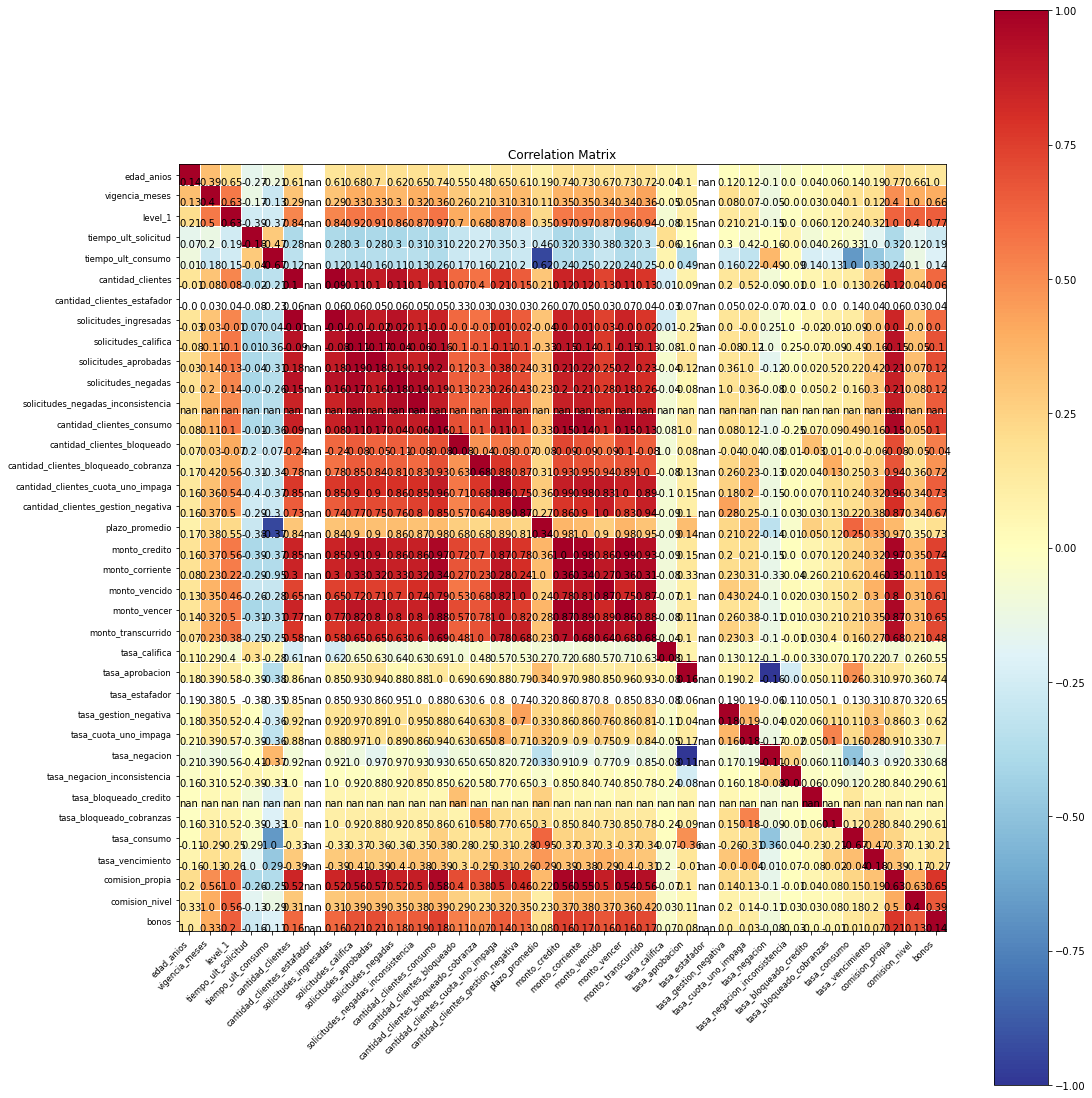

In [5]:
################################################
#MATRIZ CORRELACION DATASET ORIGINAL
################################################

plt.rcParams["figure.figsize"] = (16, 16)

corr = dataset.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(i, j, round(corr.iloc[i,j], 2))

plt.show()


In [6]:
#Eliminar campos con correlacion baja en nuevo dataframe df
df = dataset.select_dtypes(include=['float64', 'int64'])

df= df.drop(['edad_anios','cantidad_clientes', 'tiempo_ult_solicitud','tiempo_ult_consumo',
             'cantidad_clientes_estafador','plazo_promedio', 'monto_corriente',
                     'cantidad_clientes_estafador','tasa_califica', 'tasa_aprobacion',
       'tasa_estafador', 'tasa_gestion_negativa', 'tasa_cuota_uno_impaga',
       'tasa_negacion', 'tasa_negacion_inconsistencia',
       'tasa_bloqueado_credito', 'tasa_bloqueado_cobranzas', 'tasa_consumo',
       'tasa_vencimiento' ,'tasa_estafador'],axis=1)
df.shape

(2627, 19)

In [7]:
df.head()

,vigencia_meses,level_1,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,solicitudes_negadas,solicitudes_negadas_inconsistencia,cantidad_clientes_consumo,cantidad_clientes_bloqueado,cantidad_clientes_bloqueado_cobranza,cantidad_clientes_cuota_uno_impaga,cantidad_clientes_gestion_negativa,monto_credito,monto_vencido,monto_vencer,monto_transcurrido,comision_propia,comision_nivel,bonos
1,64,14,125,113,72,35,9,45,2,0,4,3,73402.06,6830.14,59842.85,16820.75,236.689167,1242.435833,590.000000
5,51,10,62,40,26,8,3,15,0,0,0,0,11870.20,0.00,7102.85,3791.92,96.755000,116.701667,16.666667
7,4,0,1,1,1,0,0,1,0,0,0,0,8.57,0.00,0.00,0.00,0.018333,5.376667,0.000000
8,0,12,11,8,6,2,1,6,1,0,1,0,7363.90,502.67,6001.47,1276.52,16.000000,105.966667,0.000000
9,14,0,42,29,13,13,2,9,1,0,0,1,18055.35,1185.07,13429.27,6417.74,38.135833,0.000000,0.000000


### 2.1 Reducción de dimensiones

In [8]:
################################################
#REDUCCIÓN DE DIMENSIONES PCA 
################################################

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

#plt.plot(pca.explained_variance_ratio_)
#plt.ylabel('Explained Variance')
#plt.xlabel('Components')
#plt.show()

                                           PC0       PC1       PC2       PC3  \
vigencia_meses                        0.123974  0.445221 -0.095899 -0.791379   
level_1                               0.173675  0.475085 -0.050627 -0.035058   
solicitudes_ingresadas                0.239520 -0.112081 -0.301131  0.048952   
solicitudes_califica                  0.257023 -0.082851 -0.256351 -0.014891   
solicitudes_aprobadas                 0.252329 -0.056699 -0.212882  0.000246   
solicitudes_negadas                   0.247800 -0.118211 -0.274257 -0.012782   
solicitudes_negadas_inconsistencia    0.247141 -0.093160 -0.182778 -0.043620   
cantidad_clientes_consumo             0.263596 -0.059231 -0.038342  0.022134   
cantidad_clientes_bloqueado           0.192765 -0.046900 -0.253338  0.157190   
cantidad_clientes_bloqueado_cobranza  0.196852 -0.158495  0.417658 -0.036243   
cantidad_clientes_cuota_uno_impaga    0.244812 -0.114706  0.288165 -0.014604   
cantidad_clientes_gestion_negativa    0.

In [9]:
pca = PCA(n_components=2)
pca.fit(df_normalized)
#reduce a 2 dimenciones
transformada= pca.transform(df_normalized)
transformada.shape
dataset['id_distribuidor'].values

array([325, 961, 2282, ..., 15786, 15813, 15906], dtype=object)

Text(0, 0.5, 'PCA 2')

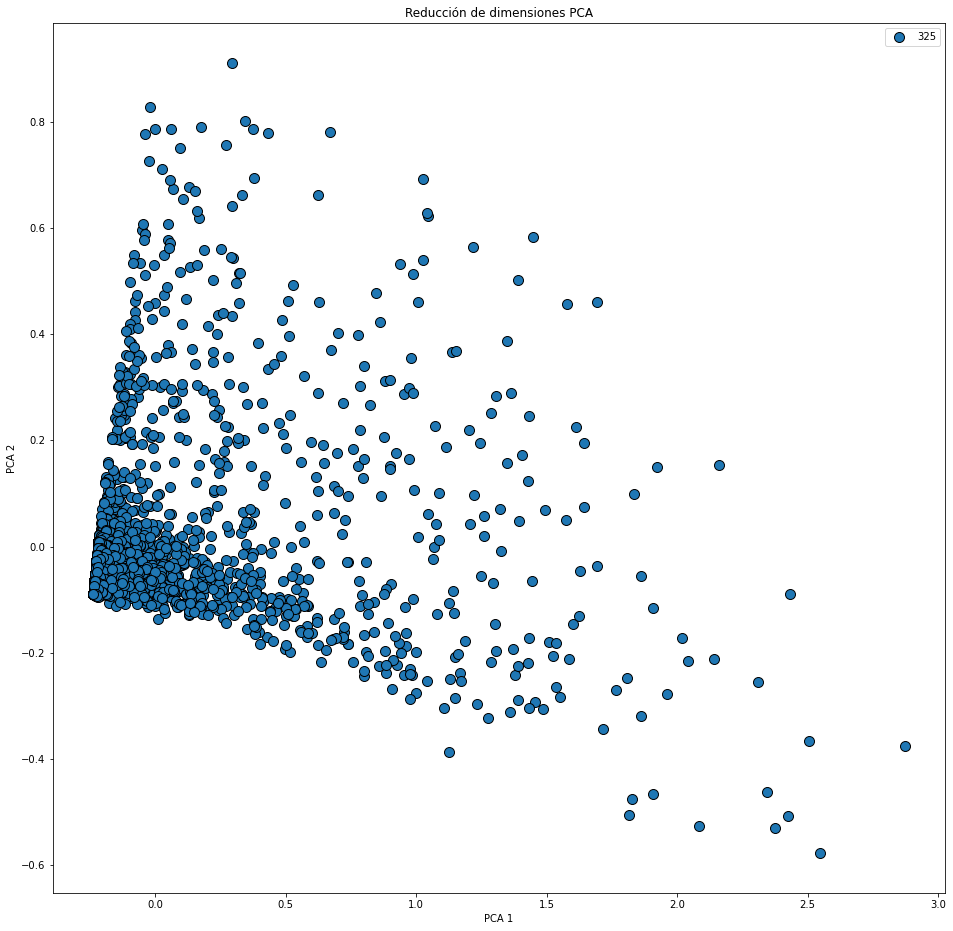

In [10]:
from sklearn.preprocessing import MinMaxScaler

escalar=MinMaxScaler()
escalar.fit(df_normalized)
escalada=escalar.transform(df_normalized)
pca.fit(escalada)
transformada=pca.transform(escalada)
mglearn.discrete_scatter(transformada[:,0], transformada[:,1])#, dataset['id_distribuidor'] )
plt.legend(dataset['id_distribuidor'].unique(), loc='best')
plt.title('Reducción de dimensiones PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0.5, 1.0, 'MATRIZ DE CORRELACION VARIABLES')

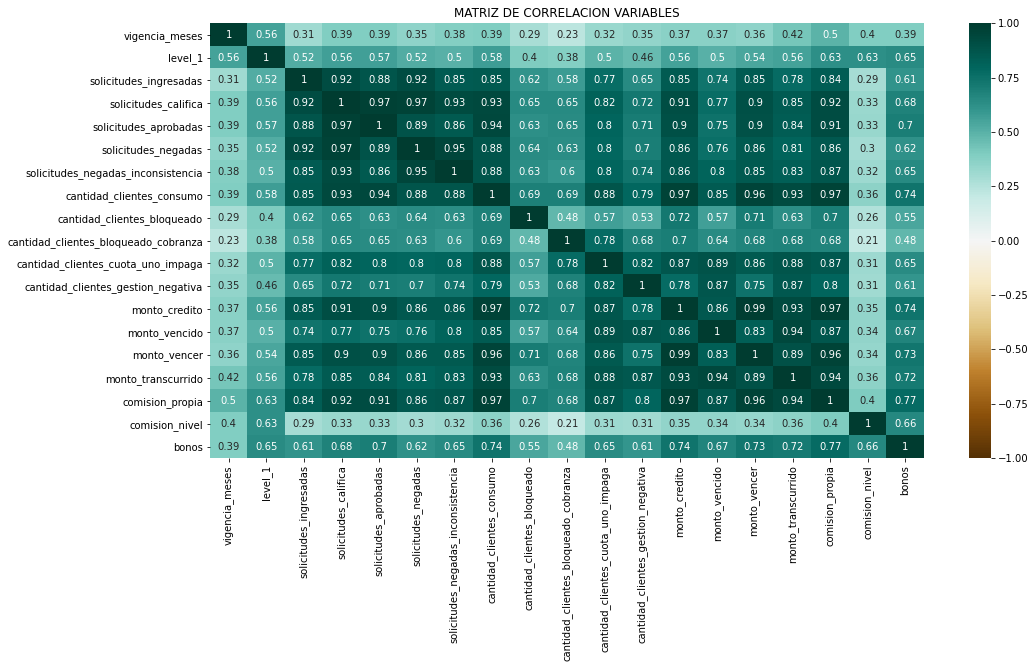

In [11]:
plt.figure(figsize=(16, 8))
#cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)   
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')#, linewidths = 0.05, linecolor= 'red', ax = ax)   
heatmap.set_title('MATRIZ DE CORRELACION VARIABLES')
#heatmap.set_xlabel('region')


### 2.2 Districucion de los datos

In [12]:
#Dataset escalado para visualizacion

df_normalized[df_normalized.columns]=escalar.transform(df_normalized[df_normalized.columns])

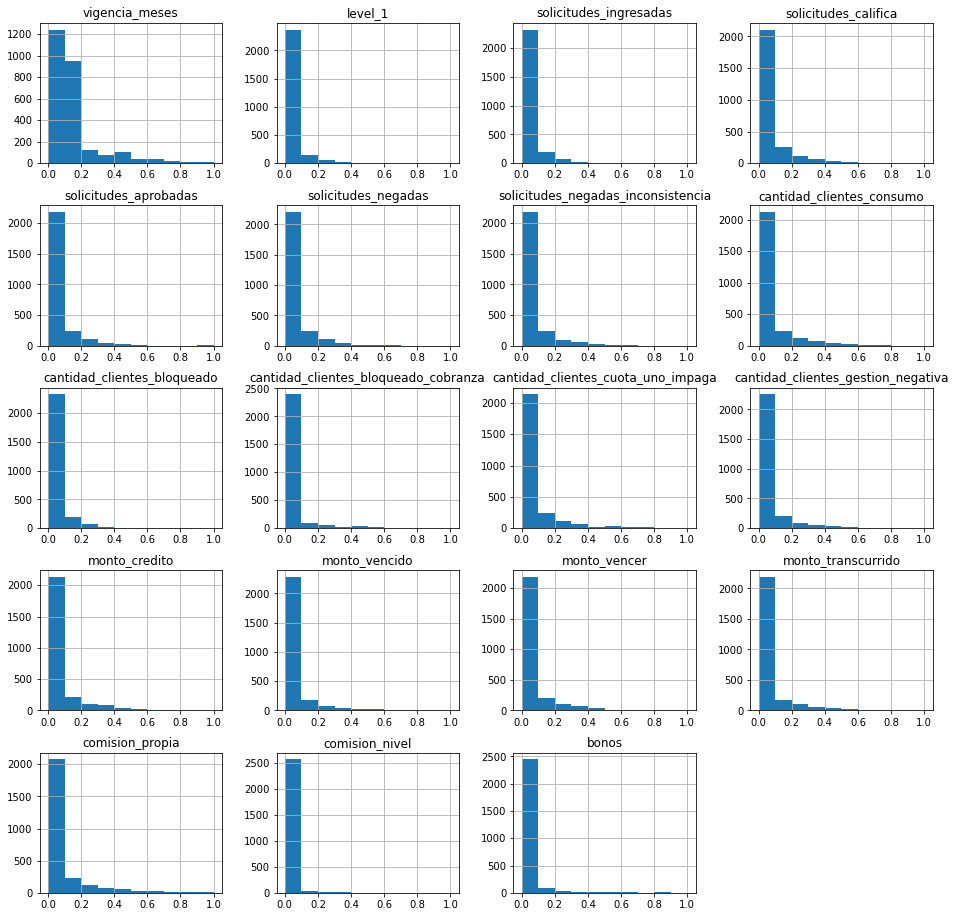

In [13]:
####################################################3
#DISTRIBUCION DE LOS DATOS
####################################################

plt.rcParams["figure.figsize"] = (16, 16)
df_normalized.hist()

#plt.title('DISTRIBUCIÓN DE LOS DATOS')
plt.show()

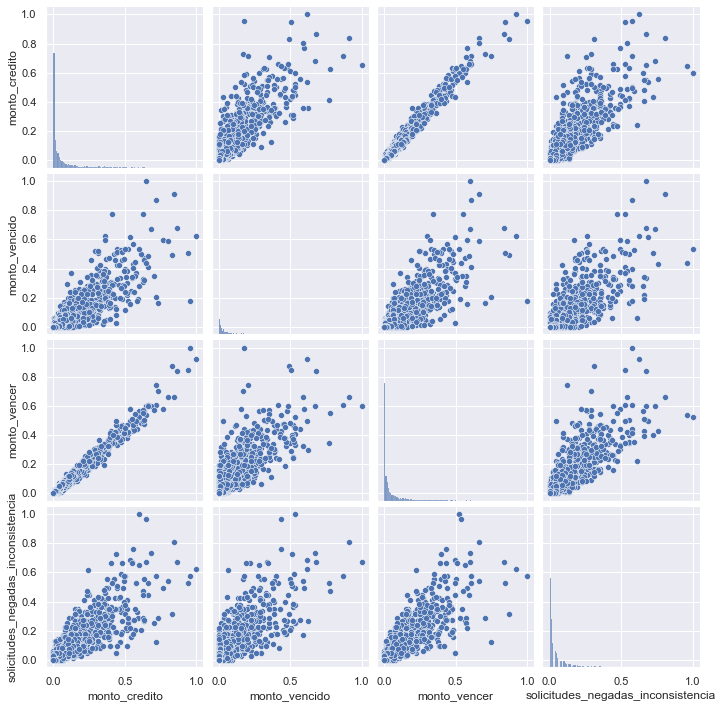

In [15]:
####################################
#CORRELACION ENTRE VARIABLES
##########################################

sns.set()
cols = ["monto_credito","monto_vencido","monto_vencer","solicitudes_negadas_inconsistencia"]
#cols = [ 'tasa_negacion_inconsistencia', 'tasa_bloqueado_credito', 'tasa_bloqueado_cobranzas']
sns.pairplot(df_normalized[cols], height = 2.5)
plt.show();

## 3. SEGMENTACIÓN KMEANS

In [16]:
# Convertir df a array
X = np.array(df_normalized.values)
X

array([[8.42105263e-01, 1.60919540e-01, 9.43683409e-02, ...,
        5.69745003e-01, 4.18042596e-01, 8.18024263e-01],
       [6.71052632e-01, 1.14942529e-01, 4.64231355e-02, ...,
        2.32903257e-01, 3.92666296e-02, 2.31080300e-02],
       [5.26315789e-02, 0.00000000e+00, 0.00000000e+00, ...,
        4.41309808e-05, 1.80908795e-03, 0.00000000e+00],
       ...,
       [1.31578947e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.31578947e-02, 0.00000000e+00, 3.80517504e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.31578947e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#############KMENs FOCALIZADO
#X = np.array(dataset[["solicitudes_negadas_inconsistencia","monto_vencido","cantidad_clientes_bloqueado"]])
X = np.array(dataset[["monto_vencido","monto_vencer","solicitudes_negadas_inconsistencia"]])

### 3.1 Elbow method

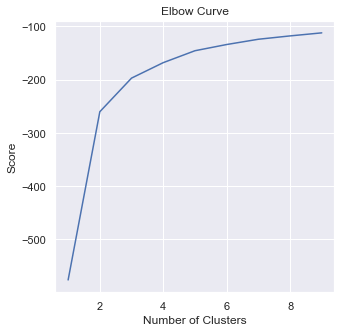

In [17]:
plt.rcParams["figure.figsize"] = (5, 5)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### 3.2 Clusterización

In [18]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)


# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03,2.627000e+03
mean,-2.929349e-15,3.996592e-15,1.170531e-15,1.173193e-16,2.326312e-15,-8.829802e-16,1.722684e-15,2.584745e-15,4.338829e-15,-1.292753e-15,-7.184331e-15,1.028890e-14,3.208997e-15,6.951720e-15,-2.354670e-15,5.983455e-16,1.744153e-15,-2.590725e-15,-6.628543e-15
std,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00,1.000190e+00
min,-9.444063e-01,-3.882192e-01,-5.100156e-01,-5.607003e-01,-5.427088e-01,-5.825104e-01,-5.507416e-01,-5.419297e-01,-3.971872e-01,-3.607628e-01,-4.404222e-01,-3.922557e-01,-5.308577e-01,-4.219437e-01,-5.290204e-01,-4.841142e-01,-5.372254e-01,-1.852223e-01,-2.961699e-01
25%,-5.311204e-01,-3.882192e-01,-4.810392e-01,-5.276880e-01,-5.114175e-01,-5.468418e-01,-5.507416e-01,-5.419297e-01,-3.971872e-01,-3.607628e-01,-4.404222e-01,-3.922557e-01,-5.308577e-01,-4.219437e-01,-5.290204e-01,-4.841142e-01,-5.372254e-01,-1.852223e-01,-2.961699e-01
50%,-2.831488e-01,-3.882192e-01,-3.844511e-01,-4.121449e-01,-3.862521e-01,-4.041673e-01,-4.371960e-01,-4.270452e-01,-3.971872e-01,-3.607628e-01,-4.404222e-01,-3.922557e-01,-4.117871e-01,-4.219437e-01,-4.088130e-01,-4.305175e-01,-4.167715e-01,-1.852223e-01,-2.961699e-01
75%,-3.517729e-02,-1.078090e-01,1.900875e-03,3.352125e-02,2.053532e-02,5.952463e-02,1.698646e-02,3.249304e-02,-3.971872e-01,-3.607628e-01,5.087664e-03,-3.922557e-01,-9.074253e-03,-1.151806e-01,1.392492e-02,-7.952106e-02,-1.288745e-02,-1.852223e-01,-1.672317e-01
max,5.337540e+00,1.180963e+01,1.218165e+01,7.758401e+00,8.875985e+00,1.011807e+01,8.873544e+00,7.787201e+00,1.406292e+01,9.903394e+00,7.578755e+00,1.016228e+01,7.569841e+00,9.768408e+00,8.603247e+00,7.861272e+00,6.382361e+00,2.242135e+01,1.086343e+01


In [19]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=3, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

kmeans.inertia_
# inertia on the fitted data
pred = kmeans.predict(data_scaled)

### 3.3 Vista 3D y 2D de variales

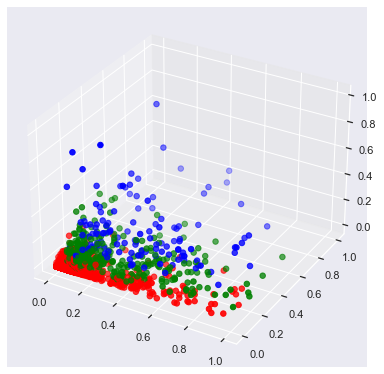

In [20]:

# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue'] #,'yellow','cyan'
asignar=[]
for row in pred:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=30)
#ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=500)

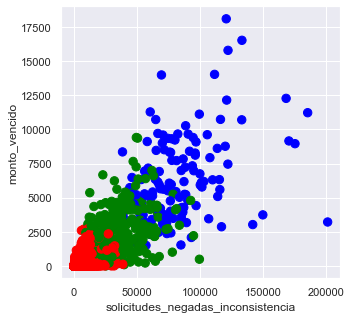

In [21]:
f1 = dataset["monto_vencer"].values
f2 = dataset['monto_vencido'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
#plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.xlabel('solicitudes_negadas_inconsistencia')
plt.ylabel('monto_vencido')
plt.show()

### 3.2 Asignar segmento en DataFrame

In [22]:
df_normalized['target'] = pred
dataset['target'] = pred
#dataset['target'] = dataset['target'].astype(object)


In [23]:
df_normalized['target'].value_counts()

0    2141
1     353
2     133
Name: target, dtype: int64

## 4. PERFIL DE SEGMENTOS

In [24]:
#Proporción de segmentos
dataGrupo= df_normalized.groupby('target').agg({ 
'solicitudes_ingresadas': [np.mean],
'solicitudes_califica': [np.mean],
'solicitudes_aprobadas': [np.mean],
'solicitudes_negadas': [np.mean],
'solicitudes_negadas_inconsistencia': [np.mean],
'cantidad_clientes_consumo': [np.mean],
'cantidad_clientes_bloqueado': [np.mean],
'cantidad_clientes_bloqueado_cobranza': [np.mean],
'cantidad_clientes_cuota_uno_impaga': [np.mean],
'cantidad_clientes_gestion_negativa': [np.mean],
'monto_credito': [np.mean],
'monto_vencido': [np.mean],
'monto_vencer': [np.mean],
'monto_vencer': [np.mean],
'comision_nivel': [np.mean],
'comision_propia': [np.mean],
'bonos': [np.mean]  
})

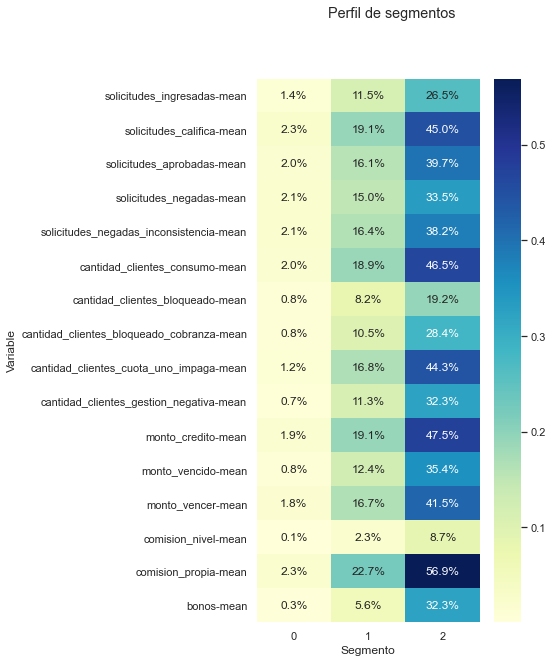

In [25]:
fig, ax = plt.subplots(figsize=(5,10))
_=sns.heatmap(np.transpose(dataGrupo) ,annot=True,fmt=".1%",cmap="YlGnBu",
xticklabels = ["0","1","2"])#
_=plt.yticks(rotation=0)
_=plt.xlabel("Segmento")
_=plt.ylabel("Variable")
_=plt.suptitle("Perfil de segmentos")
_=plt.savefig("Correlaciones Pearson.jpg")

In [26]:
print("Grupo 1: ",len(dataset[dataset['target']==0]))
print('Grupo 2 : ',len(dataset[dataset['target']==1]))
print("Grupo 3: ",len(dataset[dataset['target']==2]))

Grupo 1:  2141
Grupo 2 :  353
Grupo 3:  133


Grupo 1:  1936
Grupo 2 :  128
Grupo 3:  345

In [ ]:
#corte el run
vista.head()

### 4.1 Asignación semaforo a cada segmento

In [27]:
# Segmento con mayor proporcion se asigna semaforo rojo luego amarillo y verde
dataset['target'] = dataset['target'].astype(object)

def target(dataset):
    if dataset['target'] == 0:
        return 'Verde'
    elif dataset['target'] == 1:
        return 'Amarillo'
    else:
        return 'Rojo'

In [28]:
analizar = dataset
analizar['target'] = analizar.apply(target, axis=1)


Amarillo     353
Rojo         133
Verde       2141
Name: target, dtype: int64


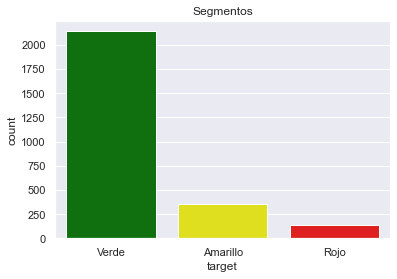

In [29]:
# Segmentos
fig, ax = plt.subplots(figsize=(6,4))
plt.title('Segmentos', fontsize = 'medium')
sns.countplot(data = analizar, x='target',palette= ['green','yellow','red'],order = analizar['target'].value_counts().index)
print(analizar.target.value_counts().sort_index())

### 4.2 Promedio de variables por perfiles


In [30]:
dataset[['tasa_califica', 'tasa_aprobacion','tasa_negacion', 'tasa_negacion_inconsistencia','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

tasa_califica                 tasa_aprobacion                  \
                  mean    median count            mean    median count   
target                                                                   
Amarillo      0.708397  0.757576   353        0.500516  0.491228   353   
Rojo          0.721679  0.764706   133        0.528703  0.523810   133   
Verde         0.767469  0.833333  2141        0.429219  0.444444  2141   

         tasa_negacion                 tasa_negacion_inconsistencia            \
                  mean    median count                         mean    median   
target                                                                          
Amarillo      0.499484  0.508772   353                     0.143405  0.139535   
Rojo          0.471297  0.476190   133                     0.142407  0.137931   
Verde         0.570781  0.555556  2141                     0.138754  0.090909   

                
         count  
target          
Amarillo   353  
Rojo       133  
Verde     2141

In [31]:
dataset[['tasa_bloqueado_credito', 'tasa_bloqueado_cobranzas','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

tasa_bloqueado_credito                 tasa_bloqueado_cobranzas  \
                           mean    median count                     mean   
target                                                                     
Amarillo               0.058869  0.045455   353                 0.051115   
Rojo                   0.055042  0.049383   133                 0.052387   
Verde                  0.038895  0.000000  2141                 0.021250   

                          
            median count  
target                    
Amarillo  0.034483   353  
Rojo      0.040816   133  
Verde     0.000000  2141

In [32]:
dataset[[ 'tasa_gestion_negativa', 'tasa_cuota_uno_impaga','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

tasa_gestion_negativa                 tasa_cuota_uno_impaga  \
                          mean    median count                  mean   
target                                                                 
Amarillo              0.084677  0.064516   353              0.117784   
Rojo                  0.095145  0.082474   133              0.120599   
Verde                 0.026765  0.000000  2141              0.044165   

                          
            median count  
target                    
Amarillo  0.108696   353  
Rojo      0.119048   133  
Verde     0.000000  2141

#'tasa_califica', 'tasa_aprobacion','tasa_negacion', 'tasa_negacion_inconsistencia',
        'tasa_gestion_negativa', 'tasa_cuota_uno_impaga',
       
       #'tasa_bloqueado_credito', 'tasa_bloqueado_cobranzas', 'tasa_consumo', 'tasa_vencimiento'

In [33]:
dataset[['monto_vencer', 'monto_vencido','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

monto_vencer                 monto_vencido               
                  mean    median count          mean   median count
target                                                             
Amarillo  33699.187847  30263.20   353   2250.786204  1991.01   353
Rojo      83565.499323  77269.26   133   6412.442857  5927.57   133
Verde      3575.009290   1187.23  2141    150.400878     0.00  2141

In [34]:
dataset[[ 'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga','cantidad_clientes_gestion_negativa','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

cantidad_clientes_bloqueado               \
                                mean median count   
target                                              
Amarillo                    1.552408      1   353   
Rojo                        3.646617      3   133   
Verde                       0.157870      0  2141   

         cantidad_clientes_bloqueado_cobranza               \
                                         mean median count   
target                                                       
Amarillo                             1.254958      1   353   
Rojo                                 3.406015      3   133   
Verde                                0.099019      0  2141   

         cantidad_clientes_cuota_uno_impaga               \
                                       mean median count   
target                                                     
Amarillo                           3.022663      3   353   
Rojo                               7.977444      7   133   
Verde                              0.219057      0  2141   

         cantidad_clientes_gestion_negativa               
                                       mean median count  
target                                                    
Amarillo                           2.141643      2   353  
Rojo                               6.135338      6   133  
Verde                              0.132181      0  2141

In [35]:
dataset[['solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

solicitudes_ingresadas              solicitudes_califica         \
                           mean median count                 mean median   
target                                                                     
Amarillo             152.526912    127   353            97.059490     90   
Rojo                 348.744361    290   133           228.030075    212   
Verde                 19.204110      9  2141            12.738907      6   

               solicitudes_aprobadas              solicitudes_negadas         \
         count                  mean median count                mean median   
target                                                                         
Amarillo   353             48.342776     43   353           44.858357     40   
Rojo       133            119.353383    110   133          100.496241     91   
Verde     2141              5.895843      3  2141            6.399346      3   

               solicitudes_negadas_inconsistencia               
         count                               mean median count  
target                                                          
Amarillo   353                          13.600567     12   353  
Rojo       133                          31.669173     29   133  
Verde     2141                           1.741709      1  2141

### 4.3 Visualizacion por perfiles

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
# plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['monto_credito', 'monto_vencido', 'monto_vencer'],
             kind='reg',
             palette=['red','green','yellow']
             #palette='gnuplot_r'
            )

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['comision_propia', 'comision_nivel', 'bonos'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=['solicitudes_ingresadas','solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia'],
             kind='reg',
             palette=['yellow','green','red'])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(dataset.dropna(), hue='target',
             height=4,
             vars=[ 'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga','cantidad_clientes_gestion_negativa','comision_propia'],
             kind='reg',
             palette=['yellow','green','red'])

## 5. GUARDAR CLUSTER

In [ ]:
analizar.to_csv('eis_fraude.csv')

analizar.to_csv('eis_faude.csv')